# Attempt at Offsides Detection

This file runs player detection, ball detection, team classification, and offside detection for a single frame

Known Problems:
1. Goalkeepers are sometimes not detected or are detected as regular players by model. When this occurs, the offside detection is inaccurate


2. Sometimes 2 goalkeepers are detected for the same team, skewing team centers. This is more rare, but when it occurs it flips the teams directions. The result is usually all defending players being marked incorrectly marked offsides
    * Possible Solution 1: Check goal keeper class id for duplicates and remove the index of the duplicate with the highest or lowest x-cord depending on team

3. In general the model only detects players, goalkeepers, referees and the ball uip to 80% accuracy. An improved model would drastically improve many of the problems that are occuring

In [787]:
# Check if GPU is being used
!nvidia-smi

Mon Dec  2 14:53:36 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   43C    P8             21W /  170W |    4386MiB /  12288MiB |     24%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [788]:
import os
import sys

# Run on GPU
os.environ["ONNXRUNTIME_EXECUTION_PROVIDER"] = "CUDAExecutionProvider"
project_root = os.path.abspath('..')
sys.path.append(project_root)

# Get Imports

In [789]:
import supervision as sv
from common.team import TeamClassifier
from tqdm import tqdm
import numpy as np
from inference import get_model
from dotenv import load_dotenv
import torch
import cv2
from sports.annotators.soccer import draw_pitch, draw_points_on_pitch, draw_pitch_voronoi_diagram
from sports.configs.soccer import SoccerPitchConfiguration

# Initialize Constants

Notes:
1. 1 Player Detected Offsides | 2 Offsides but not Detected | -->
2. 1 Player Detected Offsides IF we flip class_id during team0 > team1

In [790]:
# Setup paths for source & target videos
# Change to dynamic inputs for cloud deployment
# SOURCE_VIDEO_PATH = "../videos/08fd33_4.mp4"
SOURCE_VIDEO_PATH = "../videos/soccer_video_offside_2.mp4"
TARGET_VIDEO_PATH = "08fd33_4_result_1.mp4"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3
OFFSIDE_ID = 4
STRIDE = 30

CONFIG = SoccerPitchConfiguration()


# Load Env

In [791]:
# Load env variables
load_dotenv()
ROBOFLOW_API_KEY = os.getenv("ROBOFLOW_API_KEY")

# ID for roboflow detection model created
PLAYER_DETECTION_MODEL_ID = "football-players-detection-3zvbc/12"

# Load Player/Ball model
PLAYER_DETECTION_MODEL = get_model(
    model_id=PLAYER_DETECTION_MODEL_ID,
    api_key=ROBOFLOW_API_KEY
)

# Not enough epochs on own model -- grab model better trained model from Roboflow
# https://universe.roboflow.com/roboflow-jvuqo/football-field-detection-f07vi/model/15

# Load Pitch Detection Model
PITCH_DETECTION_MODEL_ID ="football-field-detection-f07vi/15"
PITCH_DETECTION_MODEL = get_model(
    model_id=PITCH_DETECTION_MODEL_ID, 
    api_key=ROBOFLOW_API_KEY
)

# Setup Annotators

In [792]:
# Setup class for displaying Ellipse around players
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00B400', '#FFD700', '#606060']),
    thickness=2
)

# Setup class for displaying red ellipse around offside players
offside_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#D2122E']),
    thickness=2
)

# Setup class for displaying triangle over ball
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    base=20,
    height=17,
)

# Setup class for labeling box annotations
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#D2122E']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER,
)

# Create Vertext Annotator for pitch detection
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8
)

# Create edge annotations using SoccerPitchConfiguration
edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.from_hex('00BFFF'),
    thickness=2,
    edges=CONFIG.edges
)

# External Functions

In [793]:
# Function to extract cropped images from video to identify player teams
# Only keep top half of cropped image --> top half contains torso with jersey
# Excess information (bottom half) causes model to misclassify players
# @Params: video_path<str>
# @Return: crops<arr>
def extract_crops(source_video_path: str):

    # Generate frames from source video
    # Stride: Only use every nth frame
    frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

    crops = []

    # Loop through each frame generated
    for  frame in tqdm(frame_generator, desc="collection crops"):

        # Infer object type (ie. person) with minimum confidence
        # Covert to standard format
        # Remove overlapping detections
        # Filter detections by class --> only keep players
        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)
        detections = detections.with_nmm(threshold=0.5, class_agnostic=True)
        detections = detections[detections.class_id == PLAYER_ID]
        
        # Loop through each detection coordinates
        # Crop the full player image     
        # Get the dimensions of the crop
        # Crop only the top half of the image
        # Add the top half crop to the list
        for xyxy in detections.xyxy:
            crop = sv.crop_image(frame, xyxy)
            height, width, _ = crop.shape
            top_half_crop = crop[:height // 2, :]
            crops.append(top_half_crop)
    
    return crops

In [ ]:
def new_resolve_goalkeepers_team_id(pitch_goalkeeper_xy: np.ndarray) -> np.ndarray:
    
    pitch_length = 12000
    goalkeepers_team_ids = []
    
    print(pitch_goalkeeper_xy)

    # Make sure goalkeepers were detected
    if len(pitch_goalkeeper_xy) != 0:

        # If goalkeeper is closer to right side of pitch --> team 1
        # If goalkeeper is closer to left side of pitch --> team 0
        # Use aboslute value of each side of the pitch minus the goalkeeper x-coordinate
        for i in range(len(pitch_goalkeeper_xy)):
            if abs(pitch_length - pitch_goalkeeper_xy[i][0]) < abs(0 - pitch_goalkeeper_xy[i][0]):
                pitch_goalkeeper_xy[i][0] = 1
                goalkeepers_team_ids.append(1)
            else:
                pitch_goalkeeper_xy[i][0] = 0
                goalkeepers_team_ids.append(0)

    # return the team ids of the goalkeepers
    return np.array(goalkeepers_team_ids)


In [796]:
# Currently not being used

def resolve_offside_player(players_detections: sv.Detections, pitch_players_xy: np.ndarray) -> np.ndarray:
    # Team side resolve --> team 0 always on left --> team 1 always on right
    
    ### GET GOAL KEEPER DETECTIONS IDS AND REMOVE FROM PLAYER_DETECTIONS LIST IF THEY ARE THERE ###
    ### CURRENTLY ONLY DETECTS ONE PLAYER OFFSIDE --> NEED TO DETECT MULTIPLE OFFSIDES

    temp_detections = players_detections.class_id.copy()

    longest_x = 0 # Initialize to min distance
    shortest_x = 12000 # Initialize to max distance
    longest_x_id = 999
    shortest_x_id = 999
    
    # Find the player furthest to the right and their id
    for i in range(len(pitch_players_xy)):
        if pitch_players_xy[i][0] > longest_x:
            longest_x = pitch_players_xy[i][0]
            longest_x_id = i

    # Find the player furthest to the left and their id
    for j in range(len(pitch_players_xy)):
        if pitch_players_xy[j][0] < shortest_x:
            shortest_x = pitch_players_xy[j][0]
            shortest_x_id = j
    
    # print("Longest X: ", longest_x)
    # print("Shortest X: ", shortest_x)
    # print("Longest X ID: ", longest_x_id)
    # print("Shortest X ID: ", shortest_x_id)
    # print("LONGEST TEAM: ", temp_detections[longest_x_id])
    # print("SHORTEST TEAM: ", temp_detections[shortest_x_id])

    offside_ids = []

    # Furthest left player should be team 0
    # If not --> team 1 player offside
    if temp_detections[shortest_x_id] != 0:
        offside_ids.append(shortest_x_id)
    
    # Furthest right player should be team 1
    # If not --> team 0 player offside
    if temp_detections[longest_x_id] != 1:
        offside_ids.append(longest_x_id)

    # Loop through all offside ids and set to OFFSIDE_ID
    for i in offside_ids:
        print(f"Player {i} is offside")
        players_detections.class_id[i] = OFFSIDE_ID

    # Return new list of class ids including the offside players
    return players_detections.class_id


In [797]:
def resolve_team_directions(players_detections, pitch_players_xy, goalkeepers_detections, pitch_goalkeeper_xy):
    
    team_0_xy = pitch_players_xy[players_detections.class_id == 0]
    team_1_xy = pitch_players_xy[players_detections.class_id == 1]

    # Balance the number of players by removing outliers if needed
    # Check to see if both teams have even number of players
    # If not, remove the player furthest to the right if team 0 has more detections
    # Remove furthest player to the left if team 1 has more detections
    # Idea is to balance number of players on each team to get a more accurate team center
    # Uneven detections leads to program thinking team 0 is defending the right instead of the left
    if len(team_0_xy) > len(team_1_xy):
        difference = len(team_0_xy) - len(team_1_xy)
        print("DIFFERENCE: ", difference)
        for _ in range(difference):
            # Remove the player with the largest x value from team_0 until teams are balanced in size
            largest_x_index = np.argmax(team_0_xy[:, 0])
            team_0_xy = np.delete(team_0_xy, largest_x_index, axis=0)
            print("Removed ", largest_x_index, " from team 0 (largest removed)")
    elif len(team_1_xy) > len(team_0_xy):
        difference = len(team_1_xy) - len(team_0_xy)
        print("DIFFERENCE: ", difference)
        for _ in range(difference):
            # Remove the player with the smallest x value from team_1 until teams are balanced in size
            smallest_x_index = np.argmin(team_1_xy[:, 0])
            team_1_xy = np.delete(team_1_xy, smallest_x_index, axis=0)
            print("Removed ", smallest_x_index, " from team 1 (smallest removed)")

    # Calculate the centers of each team (not including goalkeepers)
    team_0_player = team_0_xy.mean(axis=0) if len(team_0_xy) > 0 else np.array([0, 0])
    team_1_player = team_1_xy.mean(axis=0) if len(team_1_xy) > 0 else np.array([0, 0])

    # Initialize the goalkeepers positions to 0
    # Could also initialize to be equal to team_n_player
    team_0_keeper = 0
    team_1_keeper = 0

    # Check if goalkeeper detections exist
    # If they do, add the goalkeeper positions to the team centers to create more distinct team centers
    if len(pitch_goalkeeper_xy[goalkeepers_detections.class_id == 0]) > 0:
        team_0_keeper = pitch_goalkeeper_xy[goalkeepers_detections.class_id == 0][0].mean(axis=0)
    if len(pitch_goalkeeper_xy[goalkeepers_detections.class_id == 1]) > 0:
        team_1_keeper = pitch_goalkeeper_xy[goalkeepers_detections.class_id == 1][0].mean(axis=0)

    if len(pitch_goalkeeper_xy[goalkeepers_detections.class_id == 0]) == 0 and len(pitch_goalkeeper_xy[goalkeepers_detections.class_id == 1]) == 0:
        print("No goalkeepers detected")

    print("Team 0: ", team_0_player)
    print("Team 1: ", team_1_player)

    # Add team and goal keeper together and divide by 2 to get team centers
    team_0_center = (team_0_player + team_0_keeper) / 2
    team_1_center = (team_1_player + team_1_keeper) / 2

    print("Team 0 Center: ", team_0_center)
    print("Team 1 Center: ", team_1_center)

    # Swap class ids and centers in the event that team 0 center is greater than team 1 center
    if team_0_center[0] > team_1_center[0]:
        temp = team_1_center
        team_1_center = team_0_center
        team_0_center = temp

        for i in range(len(players_detections.class_id)):
            j = 0
            if players_detections.class_id[i] == 0:
                j = 1
            players_detections.class_id[i] = j

    return players_detections.class_id

In [798]:
def get_last_defenders(players_detections: sv.Detections, pitch_players_xy: np.ndarray) -> np.ndarray:
    
    left_defender_x = 12000 # Initialize to max size of 2D pitch
    right_defender_x = 0 # Initialize to min size of 2D pitch
    left_defender_id = 999
    right_defender_id = 999
    
    for i in range(len(pitch_players_xy)):

        x_pos = pitch_players_xy[i][0]

        # Team 0 is always left --> only check left defender from team 0
        if players_detections.class_id[i] == 0:
            if x_pos < left_defender_x:
                left_defender_x = x_pos
                left_defender_id = i

    
    for i in range(len(pitch_players_xy)):

        x_pos = pitch_players_xy[i][0]
        # Team 1 is always right --> only check right defender from team 1
        if players_detections.class_id[i] == 1:   
            if x_pos > right_defender_x:
                right_defender_x = x_pos
                right_defender_id = i

    return [ left_defender_id, right_defender_id ]



In [799]:
def check_offsides(players_detections, pitch_players_xy, last_defender_ids) -> np.ndarray:

    left_defender = last_defender_ids[0] # Team 0 Defender
    right_defender = last_defender_ids[1] # Team 1 Defender

    offside_ids = []

    for i in range(len(pitch_players_xy)):

        # If player is on the same team as the left defender and is further up the pitch --> offside
        if players_detections.class_id[i] == 1 and pitch_players_xy[i][0] < pitch_players_xy[left_defender][0]:
            offside_ids.append(i)
        
        # If player is on the same team as the right defender and is further up the pitch --> offside
        if players_detections.class_id[i] == 0 and pitch_players_xy[i][0] > pitch_players_xy[right_defender][0]:
            offside_ids.append(i)

    return offside_ids

In [800]:
# Transform perspective of pitch to 2D plane
class ViewTransformer:

    # Initialize points in float32 format
    # Calculate homography matrix for 2D perspective transformation
    # @Params: source<np.ndarray>, target<np.ndarray>
    # @Return: None
    def __init__(self, source: np.ndarray, target: np.ndarray):
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m, _ = cv2.findHomography(source, target)

    # Points exist in 2 dimensions
    # Expand points to 3 dimensions to match homography matrix
    # Remove extra dimension once completed
    # @Params: source<np.ndarray>, target<np.ndarray>
    # @Return: np.ndarray
    def transform_points(self, points: np.ndarray) -> np.ndarray:

        if points.size == 0:
            return points
        
        if points.shape[1] != 2:
            raise ValueError("Points must have shape (n, 2)")
        
        
        points = points.reshape(-1, 1, 2).astype(np.float32)
        points = cv2.perspectiveTransform(points, self.m)
        return points.reshape(-1, 2).astype(np.float32)

# Slice Video Frames

In [801]:
crops = extract_crops(SOURCE_VIDEO_PATH)
team_classifier = TeamClassifier()
team_classifier.fit(crops)

# Track newly detected instances of players/balls
tracker = sv.ByteTrack()
tracker.reset()

# Create video source and where to store completed video
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)

# For testing only grab a single frame and draw on it for results
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame=next(frame_generator)

player_result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
player_detections = sv.Detections.from_inference(player_result)

# Detect pitch on each frame with at least 30% confidence
# Store keypoints infered from frame result
pitch_result = PITCH_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(pitch_result)

collection crops: 6it [00:01,  5.14it/s]
Embedding extraction: 4it [00:11,  2.89s/it]


# Get & Classify Detections

In [802]:
# Get detections for ball from each frame
ball_detections = player_detections[player_detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)


# Set all detections to not include ball
# Remove overlapping detections
# Adjust class id of all remaining detections by 1 to account for BALL_ID having different detection
# Add tracker to all detections besides ball 
all_detections = player_detections[player_detections.class_id != BALL_ID]
all_detections = all_detections.with_nmm(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(all_detections)

# Define player, goalkeeper and referees from within all_detections
# Grab only frames with detected players
players_detections = all_detections[all_detections.class_id == PLAYER_ID]
goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
referee_detections = all_detections[all_detections.class_id == REFEREE_ID]

referee_detections.class_id -= 1


print(goalkeepers_detections[0])

Detections(xyxy=array([[1035.,  271., 1053.,  301.]]), mask=None, confidence=array([0.89386076]), class_id=array([1]), tracker_id=array([15]), data={'class_name': array(['goalkeeper'], dtype='<U10')})


# Team Prediction

In [803]:
# Predict team for each player using team_classifier
player_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(player_crops)

print(players_detections.class_id)

Embedding extraction: 1it [00:01,  1.91s/it]


[1 0 0 1 0 0 0 1 1 0 1 0 1 0 0 1 1 1]


# Detect Pitch

In [804]:

# Filter out keypoints with confidence less than 0.5
# Create new object with filtered key points
# Create new KeyPoints object with new key point positions
# Filter out low confidence pitch reference points
filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(xy=frame_reference_points[np.newaxis, ...])
pitch_reference_points = np.array(CONFIG.vertices)[filter]

# Pass pitch_reference_Points and frame_reference_points to do transformation
view_transformer = ViewTransformer(
    source=pitch_reference_points,
    target=frame_reference_points,
)

# Gather all the points together
# Create new KeyPoints object
pitch_all_points = np.array(CONFIG.vertices)
frame_all_points = view_transformer.transform_points(pitch_all_points)
frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])


# Transform Video to 2D Plane

In [ ]:
# 2D Plane X is from 0 - 12000

# Filter out keypoints with confidence less than 0.5
# Create new object with filtered key points
# Create new KeyPoints object with new key point positions
# Filter out low confidence pitch reference points
filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(xy=frame_reference_points[np.newaxis, ...])
pitch_reference_points = np.array(CONFIG.vertices)[filter]

# Pass pitch_reference_Points and frame_reference_points to do transformation
view_transformer = ViewTransformer(
    source=frame_reference_points,
    target=pitch_reference_points,    
)

# Get position of ball on a frame
# Frame (x,y) is captured image
# Pitch (x,y) is position of ball on 2D plane
# Transform position to 2D plane
frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_ball_xy = view_transformer.transform_points(frame_ball_xy)

# Get position of players on a frame
# Frame (x,y) is captured image
# Pitch (x,y) is position of player on 2D plane
# Transform position to 2D plane
frame_player_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_players_xy = view_transformer.transform_points(frame_player_xy)

# Get position of referees on a frame
# Frame (x,y) is captured image
# Pitch (x,y) is position of referee on 2D plane
# Transform position to 2D plane
frame_referee_xy = referee_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_referee_xy = view_transformer.transform_points(frame_referee_xy)

# Get position of goalkeepers on a frame
# Frame (x,y) is captured image
# Pitch (x,y) is position of referee on 2D plane
# Transform position to 2D plane
frame_goalkeeper_xy = goalkeepers_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_goalkeeper_xy = view_transformer.transform_points(frame_goalkeeper_xy)

goalkeepers_detections.class_id = new_resolve_goalkeepers_team_id(pitch_goalkeeper_xy)
print("Goalkeeper Team IDs: ", goalkeepers_detections.class_id)






[[11782.061   4463.1187]
 [10022.921   3588.9395]]
Goalkeeper Team IDs:  [1 1]
Detections IDs after removal:  [1 1]
Detections after removal:  Detections(xyxy=array([[1035.,  271., 1053.,  301.],
       [ 752.,  261.,  764.,  289.]]), mask=None, confidence=array([0.89386076, 0.65793306]), class_id=array([1, 1]), tracker_id=array([15, 23]), data={'class_name': array(['goalkeeper', 'goalkeeper'], dtype='<U10')})


# Offside Detection

1. Detect Players
2. Identify Player positions
3. Use homography to transform positions to 2D plane
4. Check if any player is offsides
5. Return offsides player class id
6. Setup new annotation and label, and add it to the specific player with previous class id

In [806]:
player_detections.class_id = resolve_team_directions(players_detections, pitch_players_xy, goalkeepers_detections, pitch_goalkeeper_xy)

Team 0:  [7642.769 4670.484]
Team 1:  [8088.5254 5010.727 ]
Team 0 Center:  [3821.3845 2335.242 ]
Team 1 Center:  [5160.2925 3621.393 ]


In [807]:
last_defender_ids = get_last_defenders(players_detections, pitch_players_xy)

offside_ids = check_offsides(players_detections, pitch_players_xy, last_defender_ids)

for i in offside_ids:
    print(f"Player {i} is offside")
    players_detections.class_id[i] = OFFSIDE_ID

Player 11 is offside


# Draw Pitch

[[ 8341.51     3899.6187 ]
 [10152.457    7068.42   ]
 [ 5743.7246    151.68475]]


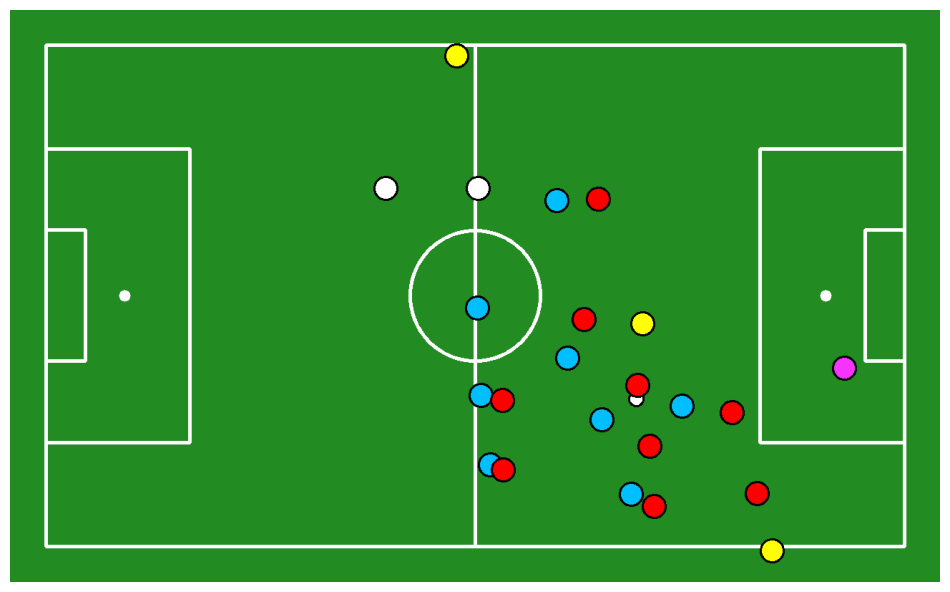

In [808]:
# Draw points on the flat 2D pitch we made
pitch = draw_pitch(config=CONFIG)
pitch = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_ball_xy,
    face_color=sv.Color.WHITE,
    edge_color=sv.Color.BLACK,
    radius=10,
    pitch=pitch
)

# Draw Team 1
pitch = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 0],
    face_color=sv.Color.from_hex("00BFFF"),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=pitch
)

# Draw Team 2
pitch = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 1],
    face_color=sv.Color.from_hex("#ff0000"),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=pitch
)

# Draw Offsides
pitch = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 4],
    face_color=sv.Color.from_hex("#f633ff"),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=pitch
)

# Draw Referee
# Can pass just pitch(x,y) to xy because there is no team classifications for referees
pitch = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_referee_xy,
    face_color=sv.Color.from_hex("#ffff00"),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=pitch
)

print(pitch_referee_xy)
# Team 0 Center:  4758.2793
# Team 1 Center:  6046.1807

pitch = draw_points_on_pitch(
    config=CONFIG,
    xy=[[4758, 2000]],
    face_color=sv.Color.from_hex("#FFFFFF"),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=pitch
)

pitch = draw_points_on_pitch(
    config=CONFIG,
    xy=[[6046, 2000]],
    face_color=sv.Color.from_hex("#FFFFFF"),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=pitch
)


sv.plot_image(pitch)

# Display Frame

[1 0 0 1 0 0 0 1 1 0 1 4 1 0 0 1 1 1 1 1 2 2 2]


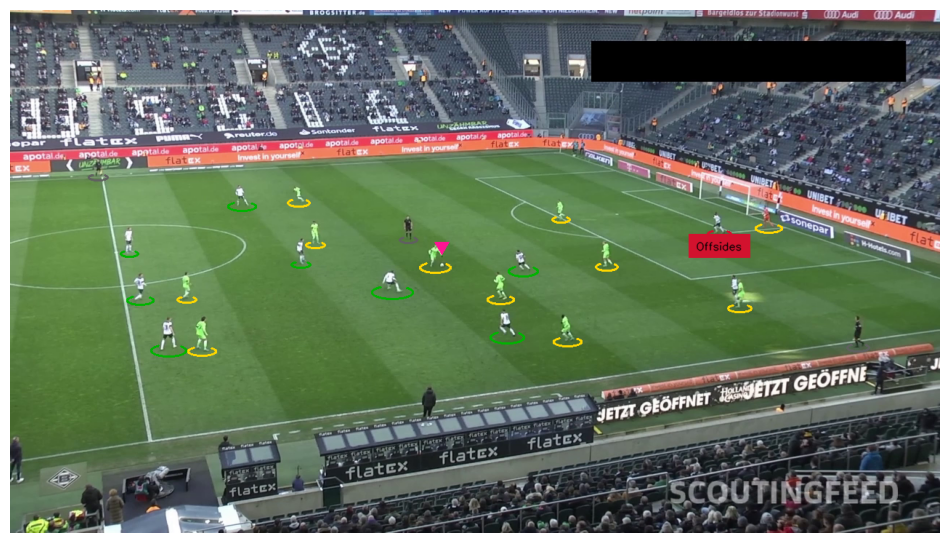

In [809]:
# Redefine all_detections to merge players and goalkeepers
all_detections = sv.Detections.merge([players_detections, goalkeepers_detections, referee_detections])

# Ensure class_id values are integers
all_detections.class_id = np.array(all_detections.class_id, dtype=int)

print(all_detections.class_id)
# Seperate offside players
offsides_detections = all_detections[all_detections.class_id == OFFSIDE_ID]

# Add labels to any offside players
labels = ["Offsides" for _ in offsides_detections.tracker_id]

# Set annotated frame to current frame
# Add ellipise & label annotator to all detections (contains players & goalkeepers)
# Add triangle annotator to ball detections
annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(annotated_frame, all_detections)
annotated_frame = offside_annotator.annotate(annotated_frame, offsides_detections)
annotated_frame = label_annotator.annotate(annotated_frame, offsides_detections, labels=labels)
annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections)

# Plot single frame image for testing results
sv.plot_image(annotated_frame)